The goal of this homework is to evaluate your coding skills, style and maturity. To demonstrate those, submit the below described tasks.

Homework instructions Implement an application processor which can process events in “streaming” manner. We like to see code, preferably Javascript. An obfuscated sample dataset to be used as input is provided here: http://ew1-fscdev-ds-public.s3-website-eu-west-1.amazonaws.com/obfuscated_data.xz (a 58MB compressed file containing some 1.500.000 events). These events represent typical product behavior events, such as product launches, purchases, user interactions, etc, from various devices and platforms.

Using this processor, try to answer at least some of the **following questions**:

- How many times has a particular product has been launched during this time period? How many first-time launches can you detect for this product?
- Can you detect duplicate events? How?
- Do you observe anything weird in timestamps?
- What kind of statistics do you think are interesting? How could you visualize this?
- How would you store the data so that further processing and/or analysis would be easy?
- If you should prepare a maintenance time for the processor, when would you do it in order to cause minimal impact to products?
- Which device has longest ‘activity time’ max('first event – latest event')

**Events and data format**:

- The data file contains one event per line
- Each event is in json format
- Certain fields have been obfuscated. These values are still comparable to each other when trying to match and compare events.
- The events contain a lot of information. 

The following **fields** might be of particular importance (but feel free to find/use others):
- type – describes what kind of event occured (launch, purchase, user_interaction, etc) •	Depending on the type, certain other packages might be available. If for example type is “purchase”, there is a “purchase” package containg information about the actual purchase. 
- source – the name of the product. This is obfuscated to show product-a, product-b, etc. 
- event_id – a unique ID for this particular event
- application – a package containing information about the application
- time – a package containing information about when the event was sent (by the device) and when it was received
- device – a package containing information about the device.
- device.device_id – an identifier for this device. This can be used to find events from the same device
- sender_info – a package containing information about the sending device.
- sender_info.geo.country – the country where the event originated from
- sender_info.geo.ll – the longitude and latitude where the event originated from


In [1]:
import os.path
import json
import ijson
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import folium
from folium import plugins

In [2]:
# To set the data path of json dataset

data_path = os.path.join(os.path.dirname('__file__'), "Data/obfuscated_data_array.json")

### How many times has a particular product has been launched during this time period?

To calculate the times a product be launched, firstly it needs to filter all the launch events from dataset, then to split them based on different products and calculate the number of each product.

In [3]:
# To select the data need to be extracted
launch_columns = [
    'event_id',
    'source',
    'type',
    'time',
    'device_id'
]

# extract the events data
launch_events = []

with open(data_path, 'r') as f:
    objects = ijson.items(f, 'item')
    for row in objects:
        selected_row = []
        if row['type'] == "launch":
            for item in launch_columns:
                if item == "device_id":
                    selected_row.append(row['device'][item])
                elif item == "time":
                    selected_row.append(row[item]['send_timestamp'])
                else:
                    selected_row.append(row[item])
            launch_events.append(selected_row)

In [4]:
# To create a pandas dataframe from the events list
launch_df = pd.DataFrame(launch_events, columns=launch_columns)

# To preview the dataframe for first 5 rows.
launch_df.head()

,event_id,source,type,time,device_id
0,7c51ab3d-05c0-48ce-9035-a918f9457a16,product-a,launch,1433664323627,45beebf6372d236330ea501930fbab244285da53
1,34f02316-c294-43b0-9b99-0a913b054539,product-a,launch,1433661170085,cad557ce6377f92415590383efcd8edf310e8cc4
2,f80986d7-da49-47be-bf6f-d6e76cf45fe7,product-a,launch,1433661523527,cad557ce6377f92415590383efcd8edf310e8cc4
3,590aea5b-6280-41a3-a17e-abeb37f184c8,product-a,launch,1433678438984,cd6b1cc48a15ba7b172fd8edfa118e4f9c155c03
4,5eebad82-c332-491f-8946-b922825ca780,product-a,launch,1433684479349,07ca3ff6f7288c4861597e7f0561ba1a79e16370


In [5]:
# To create another dataframe to count for dfferent products from 'source' column
product_df = pd.DataFrame(launch_df['source'].value_counts().sort_index()) # count values for products and sort by product names
product_df.reset_index(inplace=True) # abstratc the product name to be a column
product_df.columns = ['product', 'values'] # rename columns with more clear names
product_df

,product,values
0,product-a,11932
1,product-b,168859
2,product-c,16690
3,product-d,223


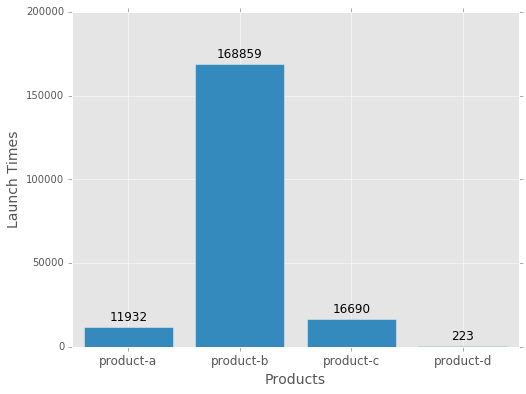

In [6]:
# To plot the count values for each products with matplotlib

plt.figure(figsize=(8,6)) # set a new figure
x = range(len(product_df))  # number of x-axis

product_launch_bar = plt.bar(x, list(product_df['values']), align='center') # bar plot all the values
plt.xticks(x, list(product_df['product']), fontsize=12) # set xticks by product name
plt.ylim(0, 200000) # set ylim to mark annotation later
plt.xlabel('Products', fontsize=14)
plt.ylabel('Launch Times', fontsize=14)

# To set a method for labeling the exact number on the bar chart
def autolabel(rects):
    # attach some annotation labels
    for rect in rects:
        height = int(rect.get_height())
        plt.annotate(height, 
                (rect.get_x() + rect.get_width() / 2., height), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                fontsize=12,
                textcoords='offset points')

autolabel(product_launch_bar) # lable the current bar chart

### How many first-time launches can you detect for this product?

To count the first-time launches for a product, if we took all the first launch events for each product on devices as the first-time launches during this period, we could count the unique device number as first-time launches. I will take product-b as an example.

In [7]:
# To create a new dataframe for all the launch events of product-b
b_launch_df = launch_df[launch_df['source']=='product-b']

# To count the unique device number as first-time launches
b_first_launch_count = len(launch_df['device_id'].unique())
print("There are %d first-time launches of product-b in this period." % b_first_launch_count)

There are 36532 first-time launches of product-b in this period.


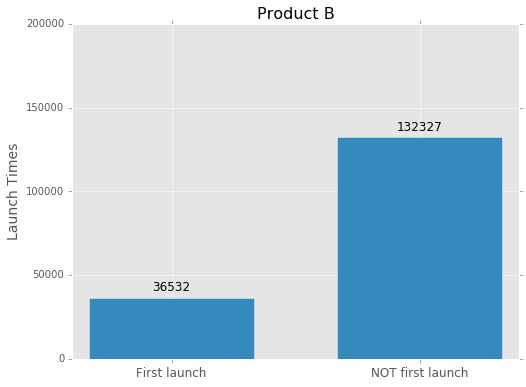

In [8]:
# To calculate the non-first_launch times and make a list for plot
launch_count = [b_first_launch_count, len(b_launch_df['device_id']) - b_first_launch_count]

plt.figure(figsize=(8,6))  # set a new figure
x = range(len(launch_count))  # number of x-axis
width = 1/1.5  # bar width

launch_bar = plt.bar(x, launch_count, width, align='center') # bar plot all the values
plt.xticks(range(2), ('First launch', 'NOT first launch'), fontsize=12)  # set xticks
plt.title('Product B', fontsize=16)
plt.ylim(0, 200000)  # set ylim to mark annotation later
plt.ylabel('Launch Times', fontsize=14)

autolabel(launch_bar)  # lable the current bar chart

### Can you detect duplicate events? How?

To detect duplicate events in the dataset, we can use unique() and value_counts() methods in pandas to show the frequency of event_id. If an event_id appeard more than one time, then it's a duplicate event.

In [9]:
# To select the data need to be extracted
duplicate_check_columns = [
    'event_id',
    'device_id'
]

# extract the events data
duplicate_check_events = []

with open(data_path, 'r') as f:
    duplicate_check_objects = ijson.items(f, 'item')
    for row in duplicate_check_objects:
        selected_row = []
        for item in duplicate_check_columns:
            if item == "device_id":
                selected_row.append(row['device'][item])
            else:
                selected_row.append(row[item])
        duplicate_check_events.append(selected_row)

In [10]:
# To create a pandas dataframe from the duplicate_check_events list
duplicate_check_df = pd.DataFrame(duplicate_check_events, columns=duplicate_check_columns)

# To preview the dataframe by first 5 rows.
duplicate_check_df.head()

,event_id,device_id
0,771ae5e3-c9d0-4950-b349-55ceeb35f7ee,498d4aec0a5a027cc43860ea066a475a33e4380e
1,11bd8781-0a87-44e6-b0e2-a0325674b413,498d4aec0a5a027cc43860ea066a475a33e4380e
2,13680a39-3c53-4ae7-8c0d-df5a6808b801,f5aa0fa7d0c353ea5910a4426cbdd78660404790
3,7c51ab3d-05c0-48ce-9035-a918f9457a16,45beebf6372d236330ea501930fbab244285da53
4,34f02316-c294-43b0-9b99-0a913b054539,cad557ce6377f92415590383efcd8edf310e8cc4


In [11]:
# To count the total_events_number, unique_events_number and duplicate_events_number
total_events_number = len(duplicate_check_df)
unique_events_number = len(duplicate_check_df['event_id'].unique())
duplicate_events_number = total_events_number - unique_events_number

print("The total events number is %d, and the unique events number is %d, so in dataset %d events appeard more than once." 
      % (total_events_number, unique_events_number, duplicate_events_number))

The total events number is 1515859, and the unique events number is 1512184, so in dataset 3675 events appeard more than once.


In [12]:
# To create another dataframe to list duplicate events

duplicate_events_df = pd.DataFrame(duplicate_check_df['event_id'].value_counts()) # count values for events
duplicate_events_df.reset_index(inplace=True)  # abstratc the event_id to be a column
duplicate_events_df.columns = ['event_id', 'frequency']  # rename columns with more clear names
duplicate_events_df[duplicate_events_df['frequency'] > 1] # filter the duplicate events and show the results

,event_id,frequency
0,8F32E867-525F-4663-A04D-9E94D99366EA,78
1,233E4AA0-B35E-487A-A709-FC9602440A62,78
2,536BB8B1-9204-4A48-9DEE-BC45CCF5DA56,78
3,889F339C-C5D8-420A-9D02-F98F21E7C10B,78
4,82732033-1A45-48E3-87E4-F24CBABA747C,78
5,CA084D64-0DB5-40EF-A021-6849AF507A91,78
6,CAE84F6E-7C39-4CFC-A77F-B2AED8AFF73C,78
7,A94CD028-F4D8-4BAE-9583-497B66EF2DAE,78
8,90F4EA71-8EED-4044-A961-2630B574952E,78
9,81C2A7C7-06AC-41B7-A36D-61E7DC445598,78


In [13]:
print("%d events have been duplicated in this dataset." % 2512)

2512 events have been duplicated in this dataset.


### Do you observe anything weird in timestamps?

There are 3 time related variables in the dataset. Through a preprocessing of first 200,000 objects in dataset, I found that the 'timestamp' variables are weird. Lots of 'timestamp' are missed after 180,000 - 190,000 objects. For left 'timestamp', some are much later than time.create_timestamp (days), some are even earlier than time.create_timestamp. So the 'timestamp' is not a reliable variable for analysis. I just want to find out the distribution of these 'timestamp' and the weird values from them.

In [14]:
# To select the data need to be extracted
time_columns = [
    'event_id',
    'source',
    'type',
    'create_time',
    'send_time',
    'timestamp',
    'device_id'
]

# extract the events data
times_events = []

with open(data_path, 'r') as f:
    time_objects = ijson.items(f, 'item')
    for row in time_objects:
        selected_time_row = []
        for item in time_columns:
            if item == "device_id":
                selected_time_row.append(row['device'][item])
            elif item == "create_time":
                selected_time_row.append(row['time']['create_timestamp'])
            elif item == "send_time":
                selected_time_row.append(row['time']['send_timestamp'])
            elif item == "timestamp":
                if item in row:
                    selected_time_row.append(row[item])
                else:
                    selected_time_row.append("")
            else:
                selected_time_row.append(row[item])
        times_events.append(selected_time_row)

In [15]:
# To create a pandas dataframe from the events list
timestamps_df = pd.DataFrame(times_events, columns=time_columns)

# To create a new dataframe for the objects that containing 'timestamp' variables
timestamp_left_df = timestamps_df[timestamps_df['timestamp'] != ""]

# To preview the dataframe by first 5 rows.
timestamp_left_df.head()

,event_id,source,type,create_time,send_time,timestamp,device_id
0,771ae5e3-c9d0-4950-b349-55ceeb35f7ee,product-a,user_interaction,1433661911699,1433661911703,1433661896414,498d4aec0a5a027cc43860ea066a475a33e4380e
1,11bd8781-0a87-44e6-b0e2-a0325674b413,product-a,user_interaction,1433661917327,1433661917329,1433661901800,498d4aec0a5a027cc43860ea066a475a33e4380e
2,13680a39-3c53-4ae7-8c0d-df5a6808b801,product-a,metric,1433663295606,1433663295843,1433663296790,f5aa0fa7d0c353ea5910a4426cbdd78660404790
3,7c51ab3d-05c0-48ce-9035-a918f9457a16,product-a,launch,1433664323610,1433664323627,1433664318952,45beebf6372d236330ea501930fbab244285da53
4,34f02316-c294-43b0-9b99-0a913b054539,product-a,launch,1433661170041,1433661170085,1433664527787,cad557ce6377f92415590383efcd8edf310e8cc4


In [16]:
# To count how many objects have 'timestamp'

print("Only %d objects in the dataset have 'timestamp'. " % len(timestamp_left_df))

Only 184731 objects in the dataset have 'timestamp'. 


In [17]:
# To convert the timestamp format to python datetime format

def time_transfer(timestamp):
    # convert a timestamp to datetime with milliseconds
    return datetime.datetime.fromtimestamp(int(timestamp)/1000)

# covert 3 time columns in dataframe
timestamp_left_df['create_time'] = timestamp_left_df['create_time'].apply(time_transfer)
timestamp_left_df['send_time'] = timestamp_left_df['send_time'].apply(time_transfer)
timestamp_left_df['timestamp'] = timestamp_left_df['timestamp'].apply(time_transfer)

# To preview the new dataframe by first 5 rows
timestamp_left_df.head()

d:\python35\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python35\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python35\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,event_id,source,type,create_time,send_time,timestamp,device_id
0,771ae5e3-c9d0-4950-b349-55ceeb35f7ee,product-a,user_interaction,2015-06-07 10:25:11.699,2015-06-07 10:25:11.703,2015-06-07 10:24:56.414,498d4aec0a5a027cc43860ea066a475a33e4380e
1,11bd8781-0a87-44e6-b0e2-a0325674b413,product-a,user_interaction,2015-06-07 10:25:17.327,2015-06-07 10:25:17.329,2015-06-07 10:25:01.800,498d4aec0a5a027cc43860ea066a475a33e4380e
2,13680a39-3c53-4ae7-8c0d-df5a6808b801,product-a,metric,2015-06-07 10:48:15.606,2015-06-07 10:48:15.843,2015-06-07 10:48:16.790,f5aa0fa7d0c353ea5910a4426cbdd78660404790
3,7c51ab3d-05c0-48ce-9035-a918f9457a16,product-a,launch,2015-06-07 11:05:23.610,2015-06-07 11:05:23.627,2015-06-07 11:05:18.952,45beebf6372d236330ea501930fbab244285da53
4,34f02316-c294-43b0-9b99-0a913b054539,product-a,launch,2015-06-07 10:12:50.041,2015-06-07 10:12:50.085,2015-06-07 11:08:47.787,cad557ce6377f92415590383efcd8edf310e8cc4


In [18]:
# To calculate the differences value between 'create_timestamp' and 'timestamp',
# then convert them to seconds format
timestamp_left_df['time_delta_seconds'] = (timestamp_left_df['create_time'] - timestamp_left_df['timestamp']) / np.timedelta64(1, 's')

# To preview the new dataframe by first 5 rows
timestamp_left_df.head()

d:\python35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,event_id,source,type,create_time,send_time,timestamp,device_id,time_delta_seconds
0,771ae5e3-c9d0-4950-b349-55ceeb35f7ee,product-a,user_interaction,2015-06-07 10:25:11.699,2015-06-07 10:25:11.703,2015-06-07 10:24:56.414,498d4aec0a5a027cc43860ea066a475a33e4380e,15.285
1,11bd8781-0a87-44e6-b0e2-a0325674b413,product-a,user_interaction,2015-06-07 10:25:17.327,2015-06-07 10:25:17.329,2015-06-07 10:25:01.800,498d4aec0a5a027cc43860ea066a475a33e4380e,15.527
2,13680a39-3c53-4ae7-8c0d-df5a6808b801,product-a,metric,2015-06-07 10:48:15.606,2015-06-07 10:48:15.843,2015-06-07 10:48:16.790,f5aa0fa7d0c353ea5910a4426cbdd78660404790,-1.184
3,7c51ab3d-05c0-48ce-9035-a918f9457a16,product-a,launch,2015-06-07 11:05:23.610,2015-06-07 11:05:23.627,2015-06-07 11:05:18.952,45beebf6372d236330ea501930fbab244285da53,4.658
4,34f02316-c294-43b0-9b99-0a913b054539,product-a,launch,2015-06-07 10:12:50.041,2015-06-07 10:12:50.085,2015-06-07 11:08:47.787,cad557ce6377f92415590383efcd8edf310e8cc4,-3357.746


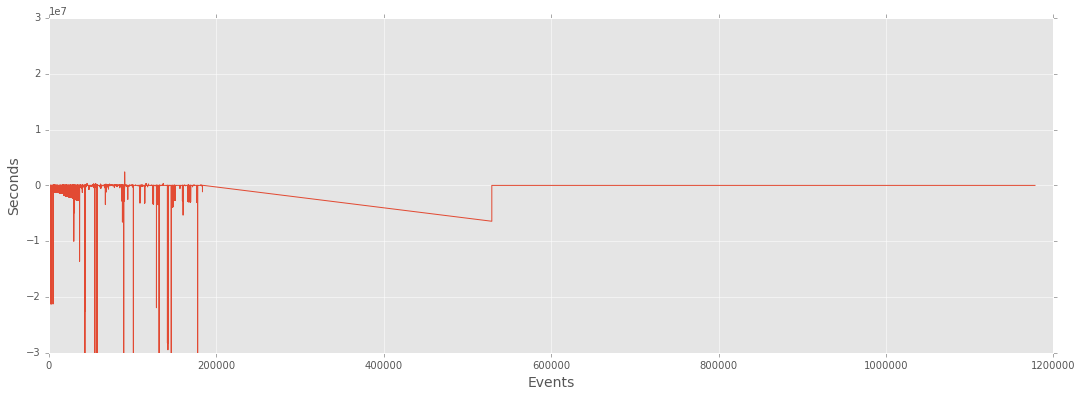

In [19]:
# To plot the differences value between 'create_timestamp' and 'timestamp' with matplotlib

plt.figure(figsize=(18,6))  # set a new figure
plt.plot(timestamp_left_df['time_delta_seconds']) # plot all the differences values
plt.xlabel('Events', fontsize=14)
plt.ylabel('Seconds', fontsize=14)
plt.ylim(-30000000, 30000000)

plt.show()

In [20]:
# To count the number of objects in which 'timestamp' earlier than 'create_time'

day_later_timestamps = len(timestamp_left_df[timestamp_left_df['time_delta_seconds'] < -86400])
print("There are %d objects in which the 'timestamp' are 1 day later than events were created." % day_later_timestamps)

There are 3316 objects in which the 'timestamp' are 1 day later than events were created.


In [21]:
# To count the number of objects in which 'timestamp' 1 day later than 'create_time' 

earlier_timestamps = len(timestamp_left_df[timestamp_left_df['time_delta_seconds'] > 0])
ratio = earlier_timestamps / len(timestamp_left_df) *100
print("There are %.2f%% objects in which the 'timestamp' are even earlier than events were created." % ratio)

There are 54.74% objects in which the 'timestamp' are even earlier than events were created.


### What kind of statistics do you think are interesting? How could you visualize this?

I'd like to know where these events happend based on longitude and latitude information. Especially, I'd like to know where the purchase happened. It may help to evaluate the effect of marketing at different places, and to find the potetial places for further marketing.

But the purchase data is too few now, I would try to use 'resume' events instead. To do this, I will extract all resume events data, and visalize them on the map through longitude and latitude information. 

In [22]:
geo_columns = [
    'event_id',
    'source',
    'type',
    'country',
    'longitude',
    'latitude',
    'device_id'
]

geo_events = []
with open(data_path, 'r') as f:
    geo_objects = ijson.items(f, 'item')
    for row in geo_objects:
        selected_geo_row = []
        for item in geo_columns:
            if item == "device_id":
                selected_geo_row.append(row['device'][item])
            elif item == "country":
                try:
                    selected_geo_row.append(row['sender_info']['geo'][item])
                except KeyError:
                    selected_geo_row.append("")
                    continue
            elif item == "longitude":
                try:
                    selected_geo_row.append(row['sender_info']['geo']['ll'][0])
                except KeyError:
                    selected_geo_row.append("")
                    continue
            elif item == "latitude":
                try:
                    selected_geo_row.append(row['sender_info']['geo']['ll'][1])
                except KeyError:
                    selected_geo_row.append("")
                    continue
            else:
                selected_geo_row.append(row[item])
        geo_events.append(selected_geo_row)

In [23]:
# # To create a pandas dataframe from the events list
geo_df = pd.DataFrame(geo_events, columns=geo_columns)

# To preview the dataframe by first 5 rows.
geo_df.head()

,event_id,source,type,country,longitude,latitude,device_id
0,771ae5e3-c9d0-4950-b349-55ceeb35f7ee,product-a,user_interaction,SE,59.3294,18.0686,498d4aec0a5a027cc43860ea066a475a33e4380e
1,11bd8781-0a87-44e6-b0e2-a0325674b413,product-a,user_interaction,SE,59.3294,18.0686,498d4aec0a5a027cc43860ea066a475a33e4380e
2,13680a39-3c53-4ae7-8c0d-df5a6808b801,product-a,metric,SE,59.1681,18.138,f5aa0fa7d0c353ea5910a4426cbdd78660404790
3,7c51ab3d-05c0-48ce-9035-a918f9457a16,product-a,launch,DE,51,9,45beebf6372d236330ea501930fbab244285da53
4,34f02316-c294-43b0-9b99-0a913b054539,product-a,launch,RU,55.7522,37.6156,cad557ce6377f92415590383efcd8edf310e8cc4


In [24]:
# To create a new dataframe for the objects that containing 'longitude' and 'latitude' variables
geo_ll_df = geo_df[geo_df['longitude'] != ""]

# To create a new dataframe for the objects from purchase events
resume_ll_df = geo_ll_df[geo_ll_df['type'] == "resume"]

# To visualize the 'longitude' and 'latitude' infomation n maps
events_map = folium.Map(location=[52.2297,  21.0122], zoom_start=4) # set the start location in Warsaw and zoom at 4
marker_cluster = folium.MarkerCluster().add_to(events_map)

for name, row in resume_ll_df.iterrows():
    # mark the map with 'longitude' and 'latitude', and see sources of events when clinking
    folium.Marker([row["longitude"], row["latitude"]], popup=row["source"]).add_to(marker_cluster)

events_map.save('resume_events.html')

![title](resume_events.png)

**So it seems that London is a main place for resume events except for Helsinki.**

### How would you store the data so that further processing and/or analysis would be easy?

I would like to use jsonb in PostgreSQL to store the original and generated json data on a single machine. Although it will take more disk space and more time to build, but it would save much more time for analysis operations. If possiable, I'd also like to choose a HDFS data storage format to store.

### If you should prepare a maintenance time for the processor, when would you do it in order to cause minimal impact to products?

In [25]:
# Select 'create_time' from timestamps_df and convert them to hour data

timestamps_df['create_time'] = timestamps_df['create_time'].apply(time_transfer)
timestamps_df['create_hour'] = timestamps_df['create_time'].apply(lambda x: x.hour)

# split and create new dataframes for each product
product_a_df = timestamps_df[timestamps_df['source']=='product-a']
product_b_df = timestamps_df[timestamps_df['source']=='product-b']
product_c_df = timestamps_df[timestamps_df['source']=='product-c']
product_d_df = timestamps_df[timestamps_df['source']=='product-d']

In [26]:
# count intercation frequent hours for each product

hour_a_df = product_a_df['create_hour'].value_counts().reset_index().sort_values(['index'])
hour_a_df.columns = ['hour', 'created_hour']
hour_b_df = product_b_df['create_hour'].value_counts().reset_index().sort_values(['index'])
hour_b_df.columns = ['hour', 'created_hour']
hour_c_df = product_c_df['create_hour'].value_counts().reset_index().sort_values(['index'])
hour_c_df.columns = ['hour', 'created_hour']
hour_d_df = product_d_df['create_hour'].value_counts().reset_index().sort_values(['index'])
hour_d_df.columns = ['hour', 'created_hour']

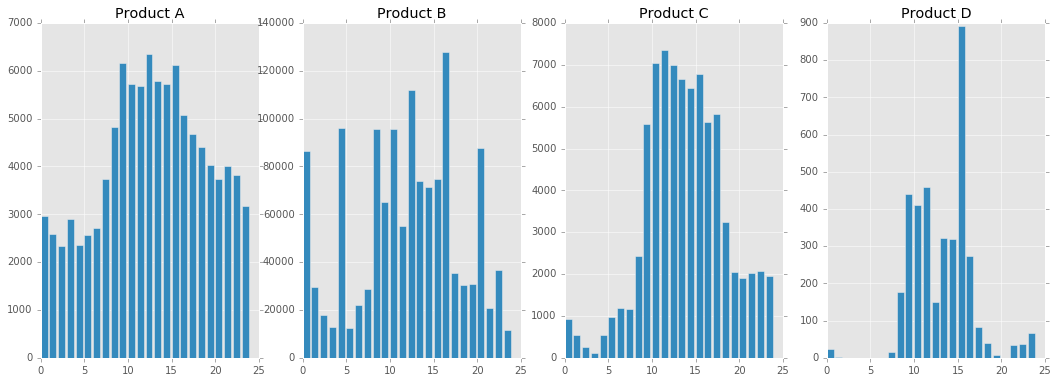

In [27]:
# To plot the above results

fig = plt.figure(figsize=(18,6)) # set a new figure

ax1 = fig.add_subplot(141)
ax1.bar(hour_a_df['hour'],hour_a_df['created_hour'])
ax1.set_title('Product A')

ax2 = fig.add_subplot(142)
ax2.bar(hour_b_df['hour'],hour_b_df['created_hour'])
ax2.set_title('Product B')

ax3 = fig.add_subplot(143)
ax3.bar(hour_c_df['hour'],hour_c_df['created_hour'])
ax3.set_title('Product C')

ax4 = fig.add_subplot(144)
ax4.bar(hour_d_df['hour'],hour_d_df['created_hour'])
ax4.set_title('Product D')

**So for every product, 2:00 - 4:00 AM seems a good time to do maintenance. For example, if it would take 1 hour for product-b  maintenance, I would choose 3:00 - 4:00 AM.**

### Which device has longest ‘activity time’ max('first event – latest event')

In [28]:
# To create a new pandas dataframe from timestamps_df
device_activity_df = timestamps_df[['device_id','source', 'create_time']]

# # A method to calculae the longest activity time for a device
# def activity_calculator(id):
#     creat_time_list = list(device_activity_df[device_activity_df['device_id']==id]['create_time'])
#     max_value = max(creat_time_list)
#     min_value = min(creat_time_list)
#     return max_value - min_value

# apply the activity_calculator method
# device_activity_df['max_activity_time'] = device_activity_df['device_id'].apply(activity_calculator)

In [29]:
# To find the active devices from duplicate_check_df
active_devices = duplicate_check_df['device_id'].value_counts()

# put active devices (more than once in device_id) in a list
active_devices_list = list(active_devices[active_devices > 1].index)

# To show how many devices are active
len(active_devices_list)

36900

In [30]:
# To filter these active devices in product-a

active_devices_df = device_activity_df.loc[device_activity_df['device_id'].isin(active_devices_list)]
a_active_devices_df = active_devices_df[active_devices_df['source']=='product-a']
a_active_devices_df.head()

,device_id,source,create_time
0,498d4aec0a5a027cc43860ea066a475a33e4380e,product-a,2015-06-07 10:25:11.699
1,498d4aec0a5a027cc43860ea066a475a33e4380e,product-a,2015-06-07 10:25:17.327
2,f5aa0fa7d0c353ea5910a4426cbdd78660404790,product-a,2015-06-07 10:48:15.606
3,45beebf6372d236330ea501930fbab244285da53,product-a,2015-06-07 11:05:23.610
4,cad557ce6377f92415590383efcd8edf310e8cc4,product-a,2015-06-07 10:12:50.041


In [31]:
# To find the first event time for each device

def first_event_check(id):
    return min(a_active_devices_df[a_active_devices_df['device_id']==id]['create_time'])

a_active_devices_df['first_activity_time'] = a_active_devices_df['device_id'].apply(first_event_check)

d:\python35\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
# To find the latest event time for each device

def last_event_check(id):
    return max(a_active_devices_df[a_active_devices_df['device_id']==id]['create_time'])

a_active_devices_df['last_activity_time'] = a_active_devices_df['device_id'].apply(last_event_check)

d:\python35\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
# To create a column of longest_activity_time for each device
# based on the first event time and latest event time

a_active_devices_df['longest_activity_time'] = a_active_devices_df['last_activity_time'] - a_active_devices_df['first_activity_time']
a_active_devices_df.head()

d:\python35\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,device_id,source,create_time,first_activity_time,last_activity_time,longest_activity_time
0,498d4aec0a5a027cc43860ea066a475a33e4380e,product-a,2015-06-07 10:25:11.699,2015-06-07 10:25:11.699,2015-12-17 07:48:31.484,192 days 21:23:19.785000
1,498d4aec0a5a027cc43860ea066a475a33e4380e,product-a,2015-06-07 10:25:17.327,2015-06-07 10:25:11.699,2015-12-17 07:48:31.484,192 days 21:23:19.785000
2,f5aa0fa7d0c353ea5910a4426cbdd78660404790,product-a,2015-06-07 10:48:15.606,2015-06-07 10:48:15.606,2015-09-19 16:36:51.270,104 days 05:48:35.664000
3,45beebf6372d236330ea501930fbab244285da53,product-a,2015-06-07 11:05:23.610,2015-06-07 11:05:23.610,2016-03-29 14:24:53.470,296 days 03:19:29.860000
4,cad557ce6377f92415590383efcd8edf310e8cc4,product-a,2015-06-07 10:12:50.041,2015-06-07 10:12:50.041,2016-03-28 15:18:53.379,295 days 05:06:03.338000


In [34]:
# device '43138fb09eb72a68108ab255b27b49fb9174d70d' shows the first event created in 1970. 
# It's a impossiable date, so I removed this device.

a_active_devices_df = a_active_devices_df[a_active_devices_df.device_id != '43138fb09eb72a68108ab255b27b49fb9174d70d']

In [35]:
a_active_devices_df.sort_values('longest_activity_time', ascending=False)

,device_id,source,create_time,first_activity_time,last_activity_time,longest_activity_time
58256,71e117cb7d7cdc88df0ccdde640ea7e6438a053d,product-a,2015-07-27 15:49:43.384,2010-01-01 02:04:08.476,2015-09-14 17:01:53.043,2082 days 14:57:44.567000
50162,71e117cb7d7cdc88df0ccdde640ea7e6438a053d,product-a,2015-07-14 06:58:58.071,2010-01-01 02:04:08.476,2015-09-14 17:01:53.043,2082 days 14:57:44.567000
70837,71e117cb7d7cdc88df0ccdde640ea7e6438a053d,product-a,2015-08-09 19:31:09.537,2010-01-01 02:04:08.476,2015-09-14 17:01:53.043,2082 days 14:57:44.567000
70839,71e117cb7d7cdc88df0ccdde640ea7e6438a053d,product-a,2015-08-09 20:11:44.919,2010-01-01 02:04:08.476,2015-09-14 17:01:53.043,2082 days 14:57:44.567000
69959,71e117cb7d7cdc88df0ccdde640ea7e6438a053d,product-a,2015-08-07 09:34:46.637,2010-01-01 02:04:08.476,2015-09-14 17:01:53.043,2082 days 14:57:44.567000
70840,71e117cb7d7cdc88df0ccdde640ea7e6438a053d,product-a,2015-08-09 20:12:03.983,2010-01-01 02:04:08.476,2015-09-14 17:01:53.043,2082 days 14:57:44.567000
50163,71e117cb7d7cdc88df0ccdde640ea7e6438a053d,product-a,2015-07-14 06:58:52.623,2010-01-01 02:04:08.476,2015-09-14 17:01:53.043,2082 days 14:57:44.567000
50164,71e117cb7d7cdc88df0ccdde640ea7e6438a053d,product-a,2015-07-14 06:58:52.612,2010-01-01 02:04:08.476,2015-09-14 17:01:53.043,2082 days 14:57:44.567000
70841,71e117cb7d7cdc88df0ccdde640ea7e6438a053d,product-a,2015-08-09 20:12:07.547,2010-01-01 02:04:08.476,2015-09-14 17:01:53.043,2082 days 14:57:44.567000
80779,71e117cb7d7cdc88df0ccdde640ea7e6438a053d,product-a,2015-08-23 06:56:47.434,2010-01-01 02:04:08.476,2015-09-14 17:01:53.043,2082 days 14:57:44.567000


**So it seems that, for product-a, the device '71e117cb7d7cdc88df0ccdde640ea7e6438a053d' has the longest longest_activity_time. It's 2082 days, more than 5 years.**